# The Planar Manipulator

In [1]:
# python libraries
import mpld3
import numpy as np

from manipulation import running_as_notebook
from manipulation.exercises.pick.plot_planar_manipulator import (
    plot_planar_manipulator,
    plot_two_planar_manipulators,
)

# enable mpld3 notebook
if running_as_notebook:
    mpld3.enable_notebook()

## Problem Description
In the lecture, we learned about forward and differential inverse kinematics. For this exercise, you will derive these equations for a simple two-link planar manipulator, using simple geometrical reasoning. As is the case with good toy problems, the two link manipulator has many insights that extend to the multi-link case, despite its apparent simplicity. 

**Learning Objectives:**
1. Compute the forward kinematics of the two-link manipulator. 
2. Calculate the inverse kinematics of the two-link manipulator.
3. Understand how the forward, inverse kinematics change for extended multi-link case
4. Derive the Jacobian of the forward kinematic map
5. Analyze the conditions for which the Jacobian is singular.  

# The Two-link Planar Manipulator 

The two-link planar manipulator is a very popular toy problem in manipulator kinematics and dynamics. The coordinate description of the two link manipulator can be seen in the below image:

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/planar_two_link.png" width="700">

## Forward Kinematics

Typically speaking, kinematics deals with mapping between frames on the robot and joint angles. Forward kinematics is the mapping from joint angles to frames on the robot. For this problem, we will limit ourselves to computing the 2D position of the end-effector from the joint angles of our manipulator. In the [monogram notation](https://drake.mit.edu/doxygen_cxx/group__multibody__quantities.html) introduced in the textbook, this means writing down the 2D position of the red point in space with respect to the green frame, ${}^A p^C$, as a function of joint angles $(q_0,q_1)$. 

**Below, your job is to write down the forward kinematics of the manipulator. You may assume both arm lengths are equal, and their length is given by L=1.0m**

NOTE: You can use `np.sin()` and `np.cos()` for trigonometric implementations.

HINT: If you can write down the 2D position of the blue point with respect to the green frame, ${}^A p^B$ as a function of $q_0$, and the position of the red point with respect to the blue point, ${}^B p^C$ as a function of $q_1$, then can you write down what ${}^A p^C$ should be?

In [55]:
def forward_kinematics(q: np.ndarray) -> np.ndarray:
    q0 = q[0]
    q1 = q[1]
    L = 1
    p_AB = L * np.array([np.cos(q0), np.sin(q0)]).T
    p_BC = L * np.array([np.cos(q1), np.sin(q1)]).T
    R_AB = np.array([
        [np.cos(q0), -np.sin(q0)],
        [np.sin(q0), np.cos(q0)]
    ])
    p_AC = p_AB + R_AB @ p_BC
    x = p_AC[0]  # Fill your code here
    y = p_AC[1]  # Fill your code here
    return np.array([x, y])

We've provided a function for you to plot the manipulator and an x-y position in 2D space, so that you can confirm that your reasoning is geometrically correct / debug any problems that occur.

Below, if the position of the x marker (your computed forward kinematics) coincides with the red marker (the actual end effector position), then your implementation should be correct. You can run it multiple times for different joint configurations.

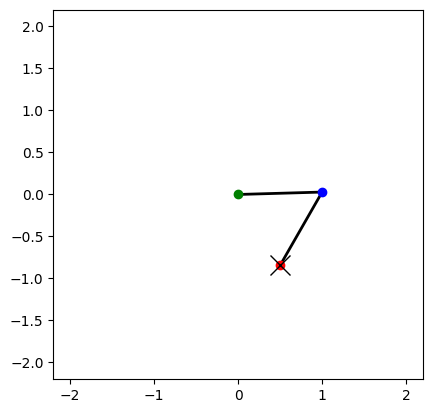

In [58]:
q = 2 * np.pi * np.random.rand(2)
plot_planar_manipulator(q, forward_kinematics(q))

## Inverse Kinematics (IK)
Inverse kinematics refers to the mapping from frames on the robot to joint angles. Here, we will focus on finding the joint angles $(q_0,q_1)$ that give a desired end-effector position ${}^A p^C$. In practice, this is often signaficantly more difficult than computing the forward kinematics.

For a two-link planar manipulator, we can derive the inverse kinematics analytically. For the manipulator of interest, it's easiest to start by finding the joint angle $q_1$. Then, the joint angle $q_0$ can be derived as a function of $q_1$.

**Below, your job is to find the two different solutions for the joint angle $q_1$ that both give the desired end-effector position [$x$, $y$]. The joint angle $q_0$ is implemented for you. You may assume both arm lengths are equal, and their length is given by L=1.0m**

HINT: Start by writing $r^2 = x^2 + y^2$ and substitute in your forward kinematics expressions from above. 

HINT: Recall the trigonometry [angle sum and difference identities](https://en.wikipedia.org/wiki/List_of_trigonometric_identities#Angle_sum_and_difference_identities)

In [73]:
def inverse_kinematics(x: float, y: float) -> tuple[np.ndarray, np.ndarray]:
    # Here, qa_b refers to the joint angle q_b in solution a.
    ## TODO: find two different solutions for the joint angle q_1
    L = 1
    cos_q1 = (x**2 + y**2 - 2*L**2) / (2*L**2)
    cos_q1 = np.clip(cos_q1, -1.0, 1.0) # In case of rounding error
    q1_1 = np.arccos(cos_q1)  # TODO: Fill your code here
    q2_1 = -np.arccos(cos_q1)  # TODO: Fill your code here

    # The solution for q_0 has been implemented for you
    q1_0 = np.arctan2(y, x) - np.arctan2(np.sin(q1_1), 1 + np.cos(q1_1))
    q2_0 = np.arctan2(y, x) - np.arctan2(np.sin(q2_1), 1 + np.cos(q2_1))

    return (np.array([q1_0, q1_1]), np.array([q2_0, q2_1]))

Below is a function to check your answer. If your answer is correct, the red dot for both arms will be in the same location as the black X. You can run this multiple times to check different positions.

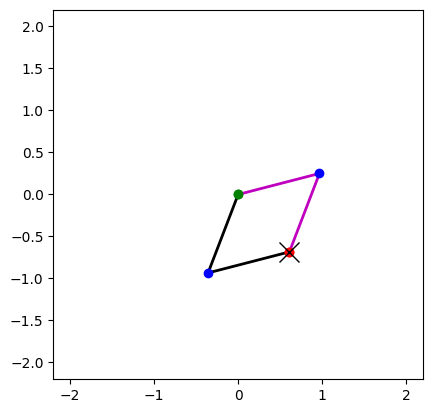

In [76]:
theta = 2 * np.pi * np.random.rand()
r = 2 * np.random.rand()
x = r * np.cos(theta)
y = r * np.sin(theta)
q1, q2 = inverse_kinematics(x, y)
plot_two_planar_manipulators(q1, q2, np.array([x, y]))

For the two-link planar manipulator, we saw that there are exactly two solutions of joint-angles for a given end-effector position. 

**Now, consider a three link planar manipulator. That is, a manipulator existing in 2-dimensional space with 3 links. For a given end-effector position, ${}^A p^C$, how many distinct solutions (of joint angles) exist? Write your answer in Gradescope (3.3)!** 

## The Translational Jacobian 

Now that we have the forward kinematics function that gives us our end-effector position given the joint angles:
$${}^Ap^C=f(q),$$

Our job now is to derive the translational Jacobian of this simple manipulator. As observed in the lecture, the translational [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) is a matrix relating how a change in end-effector position is related to changes in joint angles: 

$$d {}^Ap^C=\frac{\partial f(q)}{\partial q} dq = \mathbf{J}(q) dq.$$

If you are not familiar with vector calculus, you can write it down even more explicitly as:

$$
\mathbf{J}(q)=\frac{\partial f(q)}{\partial q} = \begin{bmatrix} 
\partial x/\partial q_0 & \partial x/\partial q_1 \\ 
\partial y/\partial q_0 & \partial y/\partial q_1 \end{bmatrix}.
$$

We recommend you get familiar with these computations since they are super common for most robotic problems! 

**Below, you will write down the 2x2 Jacobian matrix based on the forward kinematics you have derived above.**

In [79]:
def Jacobian(q: np.ndarray) -> np.ndarray:
    q0 = q[0]
    q1 = q[1]
    J = np.array(
        [
            [-np.sin(q0)-np.sin(q0+q1), -np.sin(q0+q1)],  # Fill your code here.
            [np.cos(q0)+np.cos(q0+q1), np.cos(q0+q1)],
        ]  # Fill your code here.
    )
    return J

There is one insightful analysis we can do on this Jacobian - when can we invert the Jacobian to successfully recover joint velocities from end-effector velocities? From the textbook, we've seen we can analyze the **kinematic singularities** of the manipulator through the Jacobian - your job will be to explicitly reason about what they are. 

**What are the values of $(q_0,q_1)$ for which we cannot invert the Jacobian? (i.e. what are the kinematic singularities of this manipulator?)**

HINT: You should be able to identify two classes of configurations. 

NOTE: If you've correctly identified the answer, take a moment to connect this back to the error that we saw while running the telop example when the Kuka reached too far - do you see the fundamental source of this error now?  

---

# VERIFICATION IN GRADESCOPE 

**Prerequisites:** You must complete ALL the TODOs above before these verification exercises will work!

**Instructions:** Implement the exercises below. Copy the exact numerical values (to 4 decimal places) for your verification keys, which you can copy/paste to Gradescope.

## Verification 1: Forward Kinematics

**Task:** Compute the forward kinematics for the two-link planar manipulator for the joint angles:
- $q_0 = 0.3$
- $q_1 = 0.2$

**Question:** For the joint angles above, what is the position of the end-effector $(x, y)$?

In [82]:
q = np.array([0.3, 0.2])
x, y = forward_kinematics(q)
print(f"x: {x}")
print(f"y: {y}")

x: 1.8329190510159785
y: 0.7749457452655425


## Verification 2: Inverse Kinematics

**Task:** Compute the inverse kinematics for the two-link planar manipulator when the end-effector position is $(x, y) = (-1, -0.5)$


**Question:** What robot joint angles achieve the desired end-effector position above?

In [85]:
x, y = (-1.0, -0.5)
q1, q2 = inverse_kinematics(x, y)
print(f"Solution 1: {q1}")
print(f"Solution 2: {q2}")

Solution 1: [-3.6555416  1.9551931]
Solution 2: [-1.70034849 -1.9551931 ]


## Verification 3: The Translational Jacobian

**Task:** Evaluate the two-link planar manipulator Jacobian for the joint angles $(q_0, q_1) = (0.3, 0.2)$

In [88]:
j = Jacobian(np.array([0.3, 0.2]))
print(f"dx/dq0: {j[0][0]}")
print(f"dx/dq1: {j[0][1]}")
print(f"dy/dq0: {j[1][0]}")
print(f"dy/dq1: {j[1][1]}")

dx/dq0: -0.7749457452655426
dx/dq1: -0.479425538604203
dy/dq0: 1.8329190510159787
dy/dq1: 0.8775825618903728


---

# Congratulations!

You've successfully completed the **Planar Manipulation** exercises! 

**Next:** In Notebook 2, you'll practice computing rigid transforms and learn how to design a grasp pose for a robot arm!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=defd6c91-8fd9-4ffc-82e3-0dc8da65acd7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>